In [210]:
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 


In [211]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/marmac/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /Users/marmac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/marmac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [275]:
train_df = pd.read_csv('translated_with_api/mixedFixed.csv', sep=';') #, , on_bad_lines='skip', encoding='utf-8'
train_df.head(10)


title  is_fake
0  "Λέει ότι η πολιτική ομάδα Annies List υποστηρ...        1
1  "Πότε άρχισε η παρακμή του άνθρακα; Ξεκίνησε ό...        0
2  "Η Χίλαρι Κλίντον συμφωνεί με τον Τζον Μακέιν ...        0
3  "Η νομοθεσία για τη μεταρρύθμιση της υγειονομι...        1
4  "Η οικονομική ανάκαμψη ξεκίνησε στο τέλος της ...        0
5  "Οι Chicago Bears είχαν περισσότερους αρχηγούς...        0
6  "Ο Jim Dunnam δεν έχει ζήσει στην περιοχή που ...        1
7  "Είμαι ο μόνος άνθρωπος σε αυτή τη σκηνή που ε...        0
8  "Ωστόσο, χρειάστηκαν 19,5 εκατομμύρια δολάρια ...        0
9  "Λέει ότι οι πρωτοβάθμιοι αντίπαλοι του GOP Gl...        0

<AxesSubplot: xlabel='is_fake', ylabel='count'>

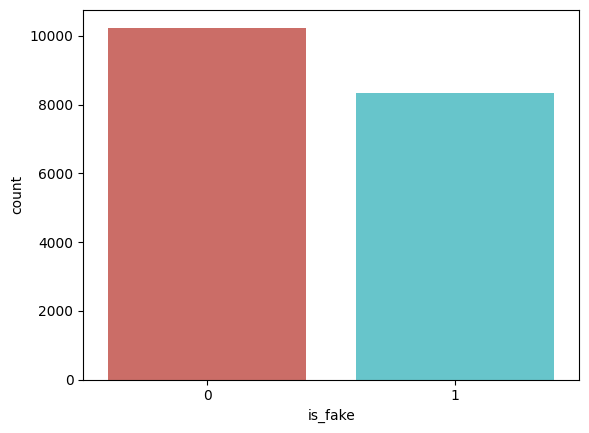

In [276]:
def create_distribution(dataFile):
    return sb.countplot(x='is_fake', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [277]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18585 entries, 0 to 18584
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    18585 non-null  object
 1   is_fake  18585 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 290.5+ KB
check finished.


In [278]:
label_train = train_df.is_fake

In [279]:
train_df = train_df.drop('is_fake', axis=1)

In [280]:
train_df.head(10)

title
0  "Λέει ότι η πολιτική ομάδα Annies List υποστηρ...
1  "Πότε άρχισε η παρακμή του άνθρακα; Ξεκίνησε ό...
2  "Η Χίλαρι Κλίντον συμφωνεί με τον Τζον Μακέιν ...
3  "Η νομοθεσία για τη μεταρρύθμιση της υγειονομι...
4  "Η οικονομική ανάκαμψη ξεκίνησε στο τέλος της ...
5  "Οι Chicago Bears είχαν περισσότερους αρχηγούς...
6  "Ο Jim Dunnam δεν έχει ζήσει στην περιοχή που ...
7  "Είμαι ο μόνος άνθρωπος σε αυτή τη σκηνή που ε...
8  "Ωστόσο, χρειάστηκαν 19,5 εκατομμύρια δολάρια ...
9  "Λέει ότι οι πρωτοβάθμιοι αντίπαλοι του GOP Gl...

In [281]:
train_df.shape

(18585, 1)

In [282]:
train_df['title'][288]

'"Ενώ αγωνιζόταν για την αυστηροποίηση των ποινών για διακρίσεις λόγω φύλου στον χώρο εργασίας, ο γερουσιαστής Glenn Grothman δήλωσε ότι δεν πιστεύει ότι οι γυναίκες ανήκουν στον χώρο εργασίας, αλλά ότι ανήκουν στο σπίτι, στο μαγείρεμα, στην καθαριότητα και στη γέννα."'

In [283]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('greek'))
new_stpwrds = ['αδιακοπα', 'αι', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'αν', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απ', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αργα', 'αργοτερο', 'αριστερα', 'αρκετα', 'αρχικα', 'ας', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γι', 'για', 'γρηγορα', 'γυρω', 'δα', 'δε', 'δεινα', 'δεν', 'δεξια', 'δηθεν', 'δηλαδη', 'δι', 'δια', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγκαιρα', 'εγκαιρως', 'εγω', 'εδω', 'ειδεμη', 'ειθε', 'ειμαι', 'ειμαστε', 'ειναι', 'εις', 'εισαι', 'εισαστε', 'ειστε', 'ειτε', 'ειχα', 'ειχαμε', 'ειχαν', 'ειχατε', 'ειχε', 'ειχες', 'εκαστα', 'εκαστες', 'εκαστη', 'εκαστην', 'εκαστης', 'εκαστο', 'εκαστοι', 'εκαστον', 'εκαστος', 'εκαστου', 'εκαστους', 'εκαστων', 'εκει', 'εκεινα', 'εκεινες', 'εκεινη', 'εκεινην', 'εκεινης', 'εκεινο', 'εκεινοι', 'εκεινον', 'εκεινος', 'εκεινου', 'εκεινους', 'εκεινων', 'εκτος', 'εμας', 'εμεις', 'εμενα', 'εμπρος', 'εν', 'ενα', 'εναν', 'ενας', 'ενος', 'εντελως', 'εντος', 'εντωμεταξυ', 'ενω', 'εξ', 'εξαφνα', 'εξης', 'εξισου', 'εξω', 'επανω', 'επειδη', 'επειτα', 'επι', 'επισης', 'επομενως', 'εσας', 'εσεις', 'εσενα', 'εστω', 'εσυ', 'ετερα', 'ετεραι', 'ετερας', 'ετερες', 'ετερη', 'ετερης', 'ετερο', 'ετεροι', 'ετερον', 'ετερος', 'ετερου', 'ετερους', 'ετερων', 'ετουτα', 'ετουτες', 'ετουτη', 'ετουτην', 'ετουτης', 'ετουτο', 'ετουτοι', 'ετουτον', 'ετουτος', 'ετουτου', 'ετουτους', 'ετουτων', 'ετσι', 'ευγε', 'ευθυς', 'ευτυχως', 'εφεξης', 'εχει', 'εχεις', 'εχετε', 'εχθες', 'εχομε', 'εχουμε', 'εχουν', 'εχτες', 'εχω', 'εως', 'η', 'ηδη', 'ημασταν', 'ημαστε', 'ημουν', 'ησασταν', 'ησαστε', 'ησουν', 'ηταν', 'ητανε', 'ητοι', 'ηττον', 'θα', 'ι', 'ιδια', 'ιδιαν', 'ιδιας', 'ιδιες', 'ιδιο', 'ιδιοι', 'ιδιον', 'ιδιος', 'ιδιου', 'ιδιους', 'ιδιων', 'ιδιως', 'ισια', 'ισως', 'καθε', 'καθεμια', 'καθεμιας', 'καθενα', 'καθενας', 'καθενος', 'καθετι', 'καθολου', 'καθως', 'και', 'κακα', 'κακως', 'καλα', 'καλως', 'καμια', 'καμιαν', 'καμιας', 'καμποσα', 'καμποσες', 'καμποση', 'καμποσην', 'καμποσης', 'καμποσο', 'καμποσοι', 'καμποσον', 'καμποσος', 'καμποσου', 'καμποσους', 'καμποσων', 'κανεις', 'κανεν', 'κανενα', 'κανεναν', 'κανενας', 'κανενος', 'καποια', 'καποιαν', 'καποιας', 'καποιες', 'καποιο', 'καποιοι', 'καποιον', 'καποιος', 'καποιου', 'καποιους', 'καποιων', 'καποτε', 'καπου', 'καπως', 'κατα', 'κατι', 'κατιτι', 'κατοπιν', 'κατω', 'κιολας', 'κλπ', 'κοντα', 'κτλ', 'κυριως', 'λιγακι', 'λιγο', 'λιγωτερο', 'λογω', 'λοιπα', 'λοιπον', 'μα', 'μαζι', 'μακαρι', 'μακρυα', 'μαλιστα', 'μαλλον', 'μας', 'με', 'μεθαυριο', 'μειον', 'μελει', 'μελλεται', 'μεμιας', 'μεν', 'μερικα', 'μερικες', 'μερικοι', 'μερικους', 'μερικων', 'μεσα', 'μετα', 'μεταξυ', 'μεχρι', 'μη', 'μηδε', 'μην', 'μηπως', 'μητε', 'μια', 'μιαν', 'μιας', 'μολις', 'μολονοτι', 'μοναχα', 'μονες', 'μονη', 'μονην', 'μονης', 'μονο', 'μονοι', 'μονομιας', 'μονος', 'μονου', 'μονους', 'μονων', 'μου', 'μπορει', 'μπορουν', 'μπραβο', 'μπρος', 'να', 'ναι', 'νωρις', 'ξανα', 'ξαφνικα', 'ο', 'οι', 'ολα', 'ολες', 'ολη', 'ολην', 'ολης', 'ολο', 'ολογυρα', 'ολοι', 'ολον', 'ολονεν', 'ολος', 'ολοτελα', 'ολου', 'ολους', 'ολων', 'ολως', 'ολωσδιολου', 'ομως', 'οποια', 'οποιαδηποτε', 'οποιαν', 'οποιανδηποτε', 'οποιας', 'οποιασδηποτε', 'οποιδηποτε', 'οποιες', 'οποιεσδηποτε', 'οποιο', 'οποιοδηποτε', 'οποιοι', 'οποιον', 'οποιονδηποτε', 'οποιος', 'οποιοσδηποτε', 'οποιου', 'οποιουδηποτε', 'οποιους', 'οποιουσδηποτε', 'οποιων', 'οποιωνδηποτε', 'οποτε', 'οποτεδηποτε', 'οπου', 'οπουδηποτε', 'οπως', 'ορισμενα', 'ορισμενες', 'ορισμενων', 'ορισμενως', 'οσα', 'οσαδηποτε', 'οσες', 'οσεσδηποτε', 'οση', 'οσηδηποτε', 'οσην', 'οσηνδηποτε', 'οσης', 'οσησδηποτε', 'οσο', 'οσοδηποτε', 'οσοι', 'οσοιδηποτε', 'οσον', 'οσονδηποτε', 'οσος', 'οσοσδηποτε', 'οσου', 'οσουδηποτε', 'οσους', 'οσουσδηποτε', 'οσων', 'οσωνδηποτε', 'οταν', 'οτι', 'οτιδηποτε', 'οτου', 'ου', 'ουδε', 'ουτε', 'οχι', 'παλι', 'παντοτε', 'παντου', 'παντως', 'παρα', 'περα', 'περι', 'περιπου', 'περισσοτερο', 'περσι', 'περυσι', 'πια', 'πιθανον', 'πιο', 'πισω', 'πλαι', 'πλεον', 'πλην', 'ποια', 'ποιαν', 'ποιας', 'ποιες', 'ποιο', 'ποιοι', 'ποιον', 'ποιος', 'ποιου', 'ποιους', 'ποιων', 'πολυ', 'ποσες', 'ποση', 'ποσην', 'ποσης', 'ποσοι', 'ποσος', 'ποσους', 'ποτε', 'που', 'πουθε', 'πουθενα', 'πριν', 'προ', 'προκειμενου', 'προκειται', 'προπερσι', 'προς', 'προτου', 'προχθες', 'προχτες', 'πρωτυτερα', 'πως', 'σαν', 'σας', 'σε', 'σεις', 'σημερα', 'σιγα', 'σου', 'στα', 'στη', 'στην', 'στης', 'στις', 'στο', 'στον', 'στου', 'στους', 'στων', 'συγχρονως', 'συν', 'συναμα', 'συνεπως', 'συνηθως', 'συχνα', 'συχνας', 'συχνες', 'συχνη', 'συχνην', 'συχνης', 'συχνο', 'συχνοι', 'συχνον', 'συχνος', 'συχνου', 'συχνου', 'συχνους', 'συχνων', 'συχνως', 'σχεδον', 'σωστα', 'τα', 'ταδε', 'ταυτα', 'ταυτες', 'ταυτη', 'ταυτην', 'ταυτης', 'ταυτο','ταυτον', 'ταυτος', 'ταυτου', 'ταυτων', 'ταχα', 'ταχατε', 'τελικα', 'τελικως', 'τες', 'τετοια', 'τετοιαν', 'τετοιας', 'τετοιες', 'τετοιο', 'τετοιοι', 'τετοιον', 'τετοιος', 'τετοιου', 'τετοιους', 'τετοιων', 'τη', 'την', 'της', 'τι', 'τιποτα', 'τιποτε', 'τις', 'το', 'τοι', 'τον', 'τος', 'τοσα', 'τοσες', 'τοση', 'τοσην', 'τοσης', 'τοσο', 'τοσοι', 'τοσον', 'τοσος', 'τοσου', 'τοσους', 'τοσων', 'τοτε', 'του', 'τουλαχιστο', 'τουλαχιστον', 'τους', 'τουτα', 'τουτες', 'τουτη', 'τουτην', 'τουτης', 'τουτο', 'τουτοι', 'τουτοις', 'τουτον', 'τουτος', 'τουτου', 'τουτους', 'τουτων', 'τυχον', 'των', 'τωρα', 'υπ', 'υπερ', 'υπο', 'υποψη', 'υποψιν', 'υστερα', 'φετος', 'χαμηλα', 'χθες', 'χτες', 'χωρις', 'χωριστα', 'ψηλα', 'ω', 'ωραια', 'ως', 'ωσαν', 'ωσοτου', 'ωσπου', 'ωστε', 'ωστοσο', 'ωχ']
stpwrds.extend(new_stpwrds)

In [284]:
for x in range(len(train_df)):
    corpus = []
    review = train_df['title'][x]
    review = re.sub(r'[^α-ωΑ-ΩίϊΐόάέύϋΰήώΊΪΌΆΈΎΫΉΏ\s]', '', review)
    print(review)
    review = nltk.word_tokenize(review)
    for y in review:
        if y not in stpwrds:  # stopwords are lowercase
            corpus.append(lemmatizer.lemmatize(y.upper()))  # lemmatizer's input must be uppercase
    review = ' '.join(corpus)
    train_df['title'][x] = review


Λέει ότι η πολιτική ομάδα   υποστηρίζει τις αμβλώσεις τρίτου τριμήνου στο και
Πότε άρχισε η παρακμή του άνθρακα Ξεκίνησε όταν το φυσικό αέριο απογειώθηκε κάτι που άρχισε να συμβαίνει από τη διοίκηση του προέδρου Τζορτζ Γ Μπους
Η Χίλαρι Κλίντον συμφωνεί με τον Τζον Μακέιν ψηφίζοντας να δώσει στον Τζορτζ Μπους το πλεονέκτημα της αμφιβολίας για το Ιράν
Η νομοθεσία για τη μεταρρύθμιση της υγειονομικής περίθαλψης είναι πιθανό να προβλέπει δωρεάν επεμβάσεις αλλαγής φύλου
Η οικονομική ανάκαμψη ξεκίνησε στο τέλος της θητείας μου
Οι   είχαν περισσότερους αρχηγούς  τα τελευταία  χρόνια από το συνολικό αριθμό των μόνιμων καθηγητών  που απολύθηκαν τις τελευταίες δύο δεκαετίες
Ο   δεν έχει ζήσει στην περιοχή που εκπροσωπεί εδώ και χρόνια
Είμαι ο μόνος άνθρωπος σε αυτή τη σκηνή που εργάστηκε ενεργά μόλις πέρυσι περνώντας μαζί με τον   κάποια από τις πιο σκληρές μεταρρυθμίσεις δεοντολογίας μετά το 
Ωστόσο χρειάστηκαν  εκατομμύρια δολάρια σε κονδύλια της Λοταρίας του Όρεγκον για να μπορέσει το λιμάνι 

In [285]:
train_df.head(15)

title
0   ΛΈΕΙ ΌΤΙ ΠΟΛΙΤΙΚΉ ΟΜΆΔΑ ΥΠΟΣΤΗΡΊΖΕΙ ΑΜΒΛΏΣΕΙΣ ...
1   ΠΌΤΕ ΆΡΧΙΣΕ ΠΑΡΑΚΜΉ ΆΝΘΡΑΚΑ ΞΕΚΊΝΗΣΕ ΌΤΑΝ ΦΥΣΙ...
2   Η ΧΊΛΑΡΙ ΚΛΊΝΤΟΝ ΣΥΜΦΩΝΕΊ ΤΖΟΝ ΜΑΚΈΙΝ ΨΗΦΊΖΟΝΤ...
3   Η ΝΟΜΟΘΕΣΊΑ ΜΕΤΑΡΡΎΘΜΙΣΗ ΥΓΕΙΟΝΟΜΙΚΉΣ ΠΕΡΊΘΑΛΨ...
4        Η ΟΙΚΟΝΟΜΙΚΉ ΑΝΆΚΑΜΨΗ ΞΕΚΊΝΗΣΕ ΤΈΛΟΣ ΘΗΤΕΊΑΣ
5   ΟΙ ΕΊΧΑΝ ΠΕΡΙΣΣΌΤΕΡΟΥΣ ΑΡΧΗΓΟΎΣ ΤΕΛΕΥΤΑΊΑ ΧΡΌΝ...
6          Ο ΈΧΕΙ ΖΉΣΕΙ ΠΕΡΙΟΧΉ ΕΚΠΡΟΣΩΠΕΊ ΕΔΏ ΧΡΌΝΙΑ
7   ΕΊΜΑΙ ΜΌΝΟΣ ΆΝΘΡΩΠΟΣ ΑΥΤΉ ΣΚΗΝΉ ΕΡΓΆΣΤΗΚΕ ΕΝΕΡ...
8   ΩΣΤΌΣΟ ΧΡΕΙΆΣΤΗΚΑΝ ΕΚΑΤΟΜΜΎΡΙΑ ΔΟΛΆΡΙΑ ΚΟΝΔΎΛΙ...
9   ΛΈΕΙ ΌΤΙ ΠΡΩΤΟΒΆΘΜΙΟΙ ΑΝΤΊΠΑΛΟΙ ΈΔΩΣΑΝ ΣΥΜΒΙΒΑ...
10  ΓΙΑ ΠΡΏΤΗ ΦΟΡΆ ΙΣΤΟΡΊΑ ΜΕΡΊΔΙΟ ΕΘΝΙΚΟΎ ΠΕΡΙΘΩΡ...
11  ΑΠΌ ΣΧΕΔΌΝ ΕΚΑΤΟΜΜΎΡΙΑ ΑΜΕΡΙΚΑΝΟΊ ΈΧΟΥΝ ΞΕΦΎΓΕ...
12  ΌΤΑΝ ΜΙΤ ΡΌΜΝΕΪ ΉΤΑΝ ΚΥΒΕΡΝΉΤΗΣ ΜΑΣΑΧΟΥΣΈΤΗΣ Ε...
13  Η ΟΙΚΟΝΟΜΊΑ ΈΧΑΣΕ ΔΙΣΕΚΑΤΟΜΜΎΡΙΑ ΔΟΛΆΡΙΑ ΛΌΓΩ ...
14  ΤΟ ΜΕΓΑΛΎΤΕΡΟ ΜΈΡΟΣ ΠΡΟΣΙΤΟΎ ΝΌΜΟΥ ΠΕΡΊΘΑΛΨΗ Έ...

In [286]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['title'], label_train, test_size=0.3, random_state=1)

In [287]:
X_train
X_train.shape

(13009,)

In [288]:
Y_train

14168    1
11497    0
7187     0
958      0
1589     0
        ..
10955    0
17289    1
5192     1
12172    0
235      1
Name: is_fake, Length: 13009, dtype: int64

In [289]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [290]:
tfidf_X_train.shape

(13009, 20723)

In [294]:
classifier = RandomForestClassifier()
classifier.fit(tfidf_X_train, Y_train)

RandomForestClassifier()

In [295]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 70.32%
Confusion matrix, without normalization


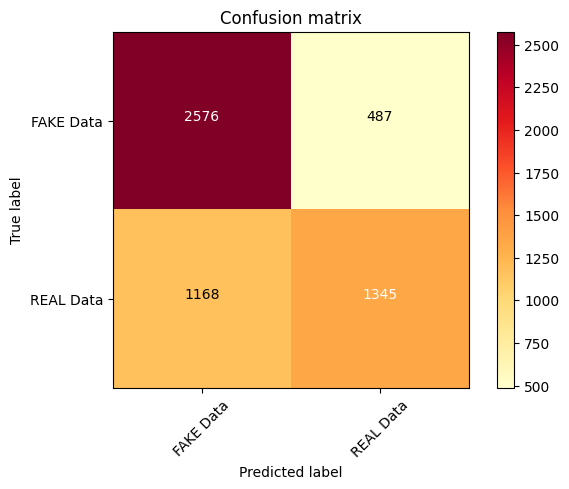

In [296]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])